In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

from model.inference import * 
from utils.access_data import *
from utils.constants import *

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [ ]:
IMG_DIR = DATA_DIR + 'GALE_CRATER/cartOrder/cartorder/'
image_file = IMG_DIR + 'layered_img_sec_100_150.pickle'
wavelengths_file = IMG_DIR + 'layered_wavelengths.pickle'

# Normalize spectra across RELAB, USGS, and CRISM per each CRISM image
# (since different CRISM images have different wavelengths)
record_reduced_spectra(wavelengths_file)

image = get_CRISM_data(image_file, wavelengths_file, CRISM_match=True)
print("CRISM image size " + str(image.shape))

## Testing
plot spectra of random pixels from image. frt0002037a_07_if165l_trr3_CAT

In [ ]:
# load "l" image, reset all NULLs to 0 
CRISM_DATA_PATH = DATA_DIR + 'GALE_CRATER_TEST_2/'
CRISM_IMG = CRISM_DATA_PATH + 'frt0000c0ef_07_if165l_trr3_CAT.img'
spy_image = envi.open(file=CRISM_IMG + '.hdr')


image_arr = spy_image[:,:,:]
img= np.where(image_arr[:,:,:] == 65535, 0, image_arr) 
# S_IMG_WAVELENGTHS = CRISM_DATA_PATH + 'l_pixel_x_201_y_200.csv'
wavelengths = get_CRISM_wavelengths(CRISM_DATA_PATH + 'pixel_x_262_y_136.csv')



print(len(wavelengths))
print(img.shape)

bands = (300, 200, 50)
from spectral import imshow
imshow(data=img, bands=bands)

In [ ]:
#  height = 450
#  width = 640

In [ ]:
from spectral import imshow

def plot_cutout_spectra(img, wavelengths, sec_width, sec_height, xstart, ystart, bands):
    """
    Visualize subsection of image and corresponding spectra to see variance
    :param sec_width: number of columns to include
    :param sec_height: number of rows to include
    :param xstart: column to start at (where 0 is left most column)
    :param ystart: row to start at (where 0 is top row)
    """
    fig, ax = plt.subplots(2, 1, constrained_layout=True,  dpi=300 ) # figsize=(4, 2), dpi=DPI
    
    height, width, num_wavelengths = img.shape
    
    avg_spectra = np.zeros(num_wavelengths)
    num_pixels = sec_width*sec_height
     
    for i in range(sec_height):
        for j in range(sec_width): 
                            # img [ height, width ]
            pixel_spectra = img[i+ystart,j+xstart]
            ax[0].plot(wavelengths, pixel_spectra, linewidth=0.5)
            avg_spectra += pixel_spectra 
            
             
    avg_spectra = avg_spectra/num_pixels
    ax[0].plot(wavelengths, avg_spectra, linewidth=1.0, color='red')
    
    ax[0].set_xlabel("Wavelength")
    ax[0].set_ylabel("Reflectance")
    ax[0].set_title("Spectra")
    ax[0].set_ylim((0, 1))

    for i in range(sec_height):
        for j in range(sec_width): 
            pixel_spectra = img[i+ystart,j+xstart] 
            ax[1].plot(wavelengths, pixel_spectra-avg_spectra)
    ax[1].set_title("Normalied Spectra (avg subtracted)")
    ax[1].set_xlabel("Wavelength")
    ax[1].set_ylabel("reflectance - avg")
    ax[1].set_ylim((0,.5))
    
    plt.show()
    
    
     
    view = imshow(data=img[xstart:(xstart+sec_height),ystart:(ystart+sec_width),:], bands=bands)
    return avg_spectra/num_pixels

    

bands = (300, 200, 50)
avg_spectra=plot_cutout_spectra(img=img,
                    wavelengths=wavelengths,
                    sec_width = 600,
                    sec_height = 400,
                    xstart = 20,
                    ystart = 20,
                    bands=bands)


## PT sampler testing

In [ ]:
from emcee import PTSampler

# mu1 = [1, 1], mu2 = [-1, -1]
mu1 = np.ones(2)
mu2 = -np.ones(2)

# Width of 0.1 in each dimension
sigma1inv = np.diag([100.0, 100.0])
sigma2inv = np.diag([100.0, 100.0])

def logl(x):
    dx1 = x - mu1
    dx2 = x - mu2

    return np.logaddexp(-np.dot(dx1, np.dot(sigma1inv, dx1))/2.0,
                        -np.dot(dx2, np.dot(sigma2inv, dx2))/2.0)

# Use a flat prior
def logp(x):
    return 0.0

In [ ]:
ntemps = 4
nwalkers = 10
ndim = 2

num_burnin_iterations = 100

sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp)
p0 = np.random.uniform(low=-1.0, high=1.0, size=(ntemps, nwalkers, ndim))
for p, lnprob, lnlike in sampler.sample(p0, iterations=num_burnin_iterations):
    pass
sampler.reset()

In [ ]:
# At each iteration, this generator for PTSampler yields

# p, the current position of the walkers.
# lnprob the current posterior values for the walkers.
# lnlike the current likelihood values for the walkers.

In [ ]:
num_iterations = 100

for p, lnprob, lnlike in sampler.sample(p0=p, lnprob0=lnprob,
                                           lnlike0=lnlike,
                                           iterations=num_iterations, 
                                        thin=10):
    pass

In [ ]:
assert sampler.chain.shape == (ntemps, nwalkers, 20, ndim)

In [ ]:
assert sampler.chain.shape == (ntemps, nwalkers, 1000, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

# etc

In [ ]:
print(3/10)

## Infer point

Try to infer single endmember.

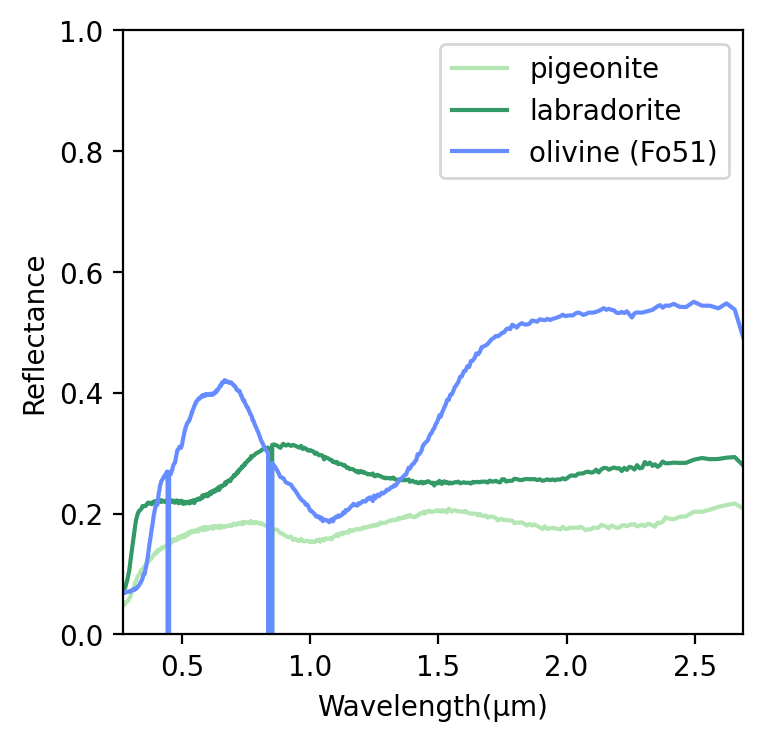

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

from model.inference import *
from model.hapke_model import get_USGS_r_mixed_hapke_estimate
from preprocessing.generate_USGS_data import generate_image

from utils.plotting import *
from utils.access_data import *
from utils.constants import *
 
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

def get_rmse(a, b): 
    return np.sqrt(np.mean((a - b)**2))


def print_error(m_actual, D_actual, m_est, D_est): 
    m_rmse = str(round(get_rmse(m_actual, m_est), 2))
    D_rmse = str(round(get_rmse(D_actual, D_est), 2))
#     print("\nEstimated m " + str(m_est))
#     print("Real m    " + str(m_actual))
#     print("RMSE for m: " + m_rmse)
#     print("\nEstimated D " + str(D_est))
#     print("Real D    " + str(D_actual))
#     print("RMSE for D: " + D_rmse)
    
    print(str(np.array(D_actual)) + ", "  + str(m_est) + ", " + str(m_rmse) + ", " + str(D_est) + ", " + str(D_rmse))
    return m_rmse, D_rmse
plot_endmembers(CRISM_match=False)

In [1]:
def test_inference(m_sample, D_sample, name):
    true_m = convert_arr_to_dict(m_sample)
    true_D = convert_arr_to_dict(D_sample)
    r_actual = get_USGS_r_mixed_hapke_estimate(m=true_m, D=true_D)
    est_m, est_D = infer_datapoint(iterations=NUM_ITERATIONS, 
                                   C=10, 
                                   V=GRAIN_SIZE_COVARIANCE,  
                                   d=r_actual)
    m_rmse, D_rmse=print_error(m_sample, D_sample, est_m, est_D)
    wavelengths = get_USGS_wavelengths()
    r_est = get_USGS_r_mixed_hapke_estimate(convert_arr_to_dict(est_m),  convert_arr_to_dict(est_D))
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    ax.plot(wavelengths, r_est, label = "Estimated", color = "orange")
    ax.plot(wavelengths, r_actual, label = "Actual", color="blue")
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Reflectance")
    ax.legend()
    ax.set_title("RMSE M: " + str(m_rmse) + ", D: " + str(D_rmse))
    plt.ylim((0, 1)) 
    plt.savefig("../output/tests/" + str(name) + ".pdf") 

Finished datapoint.
Finish with cur m [0.74 0.   0.26] but BEST m is [0.22 0.49 0.29]
[200 300 100], [0.74 0.   0.26], 0.47, [ 97. 139. 114.], 110.64


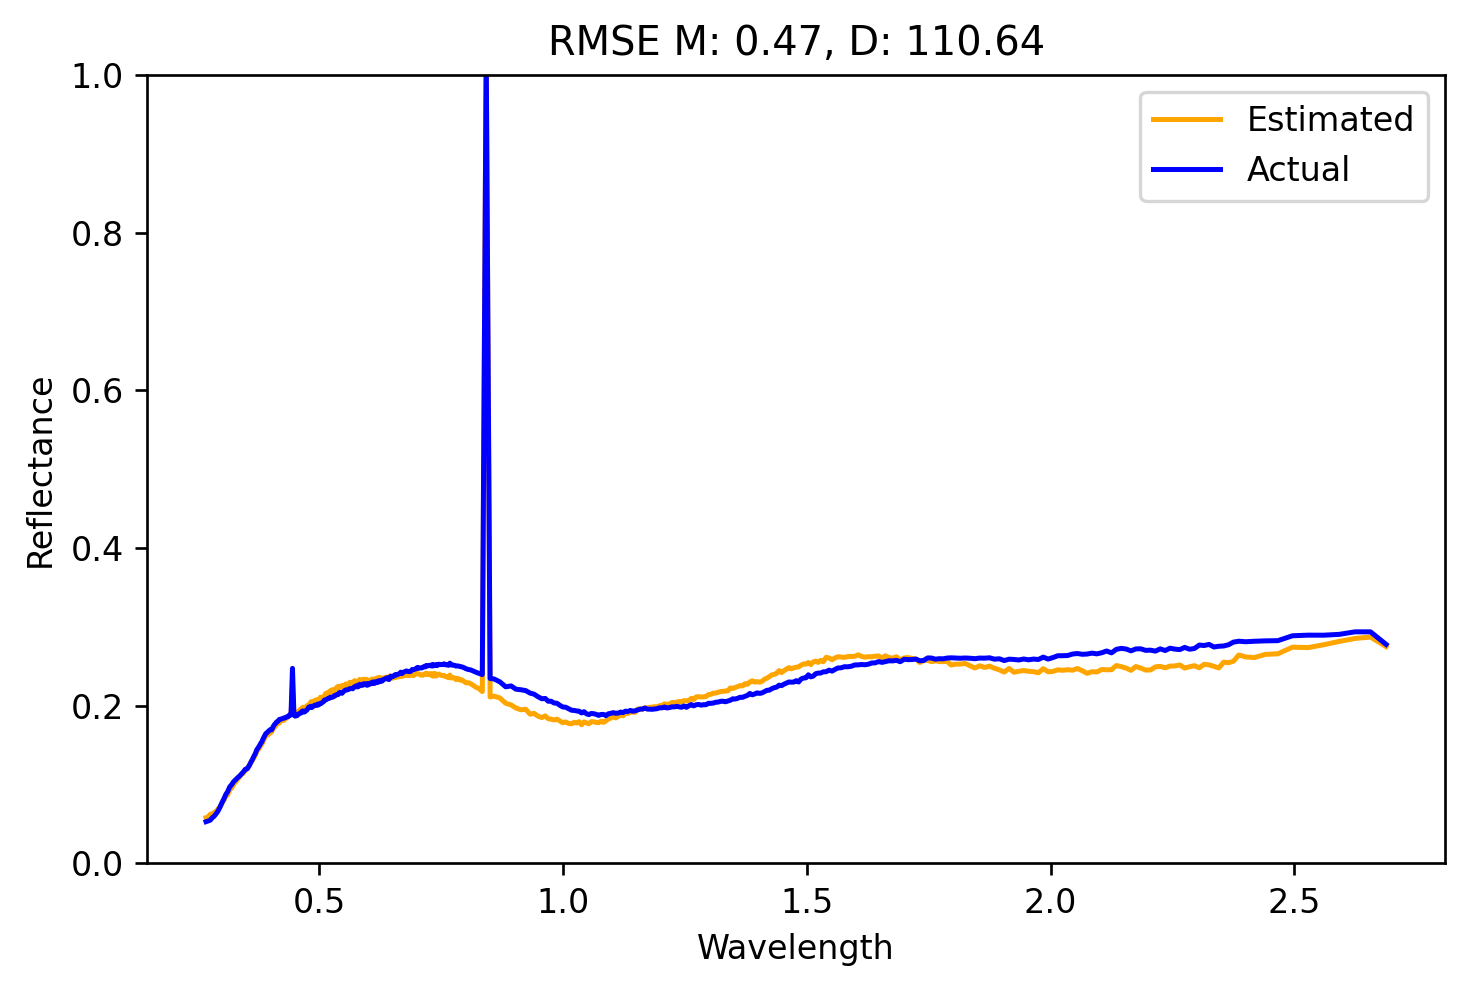

In [3]:
m_sample = [0.2,.6,0.2]
D_sample = [200, 300, 100]
GRAIN_SIZE_COVARIANCE = 50
NUM_ITERATIONS = 1500
test_inference(m_sample, D_sample, "mixed_2")

In [ ]:
# m_sample = [0.2, 0.2, 0.2, 0.2, 0.2]
D_sample = [295, 400, 162, 200, 36, 290, 162, 60, 162]
GRAIN_SIZE_COVARIANCE = 50
NUM_ITERATIONS = 1500
for i, endmember in enumerate(USGS_PURE_ENDMEMBERS):
#     if i not in [0,3,5,7,8]:
#         continue
    print("\n\n" + endmember)
    m_sample = [0,0,0,0,0,0,0,0,0]
    for si, v in enumerate(m_sample):
        if si in [0,3,5,7,8]:
            m_sample[si] = 0.05
    m_sample[i] = 0.8
    print(m_sample)
    test_inference(m_sample, D_sample, endmember)
    
    

In [ ]:
GRAIN_SIZE_COVARIANCE = 50
NUM_ITERATIONS = 200
test_inference(m_sample=[0.2, 0.2, 0.2, 0.2, 0.2],
               D_sample=[295, 200, 290, 60, 162],
               name='tester')